### **Install Dependencies**

In [1]:
!pip install qiskit==1.1.0 qiskit-aer==0.14.2 qiskit-machine-learning==0.8.2 qiskit_ibm_runtime imblearn qiskit-algorithms pylatexenc  

### **Import Dependencies**

In [44]:
# data preprocessing imports
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from imblearn.over_sampling import RandomOverSampler
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score
import seaborn as sns
from sklearn.compose import ColumnTransformer

# PyTorch
import torch
import torch.nn as nn


# Qiskit Imports (compatible with 1.1.0)
from qiskit.circuit.library import ZZFeatureMap, RealAmplitudes,TwoLocal
from qiskit_algorithms.optimizers import COBYLA
from qiskit.primitives import Sampler
from qiskit_machine_learning.algorithms.classifiers import VQC
from qiskit_aer.primitives import Sampler as AerSampler
from qiskit_aer import AerSimulator
from qiskit_machine_learning.kernels import FidelityQuantumKernel
from qiskit import QuantumCircuit
from qiskit_machine_learning.state_fidelities import ComputeUncompute
from sklearn.preprocessing import OneHotEncoder, StandardScaler
from sklearn.decomposition import PCA
from sklearn.preprocessing import OneHotEncoder, StandardScaler
from qiskit.circuit import ParameterVector
from IPython.display import display

# IBM Qauntum computer
from qiskit_ibm_runtime import QiskitRuntimeService

# Qiskit
from qiskit_machine_learning.neural_networks import EstimatorQNN
from qiskit_machine_learning.connectors import TorchConnector
from qiskit_machine_learning.algorithms.classifiers import QSVC




In [5]:
import qiskit
import qiskit_machine_learning
print(qiskit_machine_learning.__version__)
print(qiskit.__version__)

0.8.2
1.1.0


## **Import Dataset**

In [8]:
#!gdown --fuzzy https://drive.google.com/file/d/1iuhrtVJIhJ4xPlrNmUL570gBUoozB3YJ/view?usp=sharing  for colabs

In [159]:

NYPD_Smalldf = pd.read_csv('dataset/NYPD_cleaned_data.csv', low_memory=False,index_col = 0).sample(frac = 0.04,random_state=23)
NYPD_Smalldf = NYPD_Smalldf[(NYPD_Smalldf['BORO_NM'] != 'UNKOWN') & (NYPD_Smalldf['LOC_OF_OCCUR_DESC'] != 'UNKOWN')]

In [160]:
NYPD_Smalldf.shape

(1127, 29)

In [161]:
NYPD_Smalldf.head(3)

,CMPLNT_NUM,CMPLNT_FR_DT,CMPLNT_FR_TM,RPT_DT,OFNS_DESC,PD_DESC,CRM_ATPT_CPTD_CD,LAW_CAT_CD,BORO_NM,LOC_OF_OCCUR_DESC,...,Month_Abbr,Year,ADDR_PCT_CD,KY_CD,PD_CD,JURISDICTION_CODE,X_COORD_CD,Y_COORD_CD,Latitude,Longitude
166203,195065730,2019-03-23,15:20:00,03/23/2019,DANGEROUS WEAPONS,"WEAPONS, POSSESSION, ETC",COMPLETED,MISDEMEANOR,BRONX,FRONT OF,...,Mar,2019,49.0,236.0,782.0,0.0,1021917.0,251014.0,6.907381e+12,-0.16099
132797,10958619,2006-04-07,18:00:00,04/07/2006,GRAND LARCENY,"LARCENY,GRAND FROM OPEN AREAS, UNATTENDED",COMPLETED,FELONY,BRONX,INSIDE,...,Apr,2006,42.0,109.0,439.0,0.0,1012075.0,239818.0,6.864495e+12,-0.16099
138589,137099676,2014-06-05,09:00:00,06/05/2014,HARRASSMENT 2,"HARASSMENT,SUBD 3,4,5",COMPLETED,VIOLATION,BROOKLYN,INSIDE,...,Jun,2014,71.0,578.0,638.0,0.0,1002180.0,182672.0,6.649024e+12,-0.16099


### **Feature engineering**

In [162]:

NYPD_Smalldf['RPT_DT'] = pd.to_datetime(NYPD_Smalldf['RPT_DT'])

NYPD_Smalldf['RPT_YEAR'] = NYPD_Smalldf['RPT_DT'].dt.year
NYPD_Smalldf['RPT_MONTH'] = NYPD_Smalldf['RPT_DT'].dt.month
NYPD_Smalldf['RPT_DAY'] = NYPD_Smalldf['RPT_DT'].dt.day
NYPD_Smalldf['RPT_DAY_OF_WEEK'] = NYPD_Smalldf['RPT_DT'].dt.dayofweek
NYPD_Smalldf['RPT_IS_WEEKEND'] = NYPD_Smalldf['RPT_DAY_OF_WEEK'].isin([5, 6]).astype(int)


In [163]:
NYPD_Smalldf['CMPLNT_FR_DT'] = pd.to_datetime(NYPD_Smalldf['CMPLNT_FR_DT'])
NYPD_Smalldf['REPORT_DELAY'] = (NYPD_Smalldf['RPT_DT'] - NYPD_Smalldf['CMPLNT_FR_DT']).dt.days
NYPD_Smalldf['REPORT_DELAY'] = NYPD_Smalldf['REPORT_DELAY'].fillna(0).clip(lower=0)


In [164]:
def time_of_day(hour):
    if 6 <= hour < 12:
        return 'Morning'
    elif 12 <= hour < 18:
        return 'Afternoon'
    elif 18 <= hour < 24:
        return 'Evening'
    else:
        return 'Night'

NYPD_Smalldf['CMPLNT_FR_TM'] = pd.to_datetime(NYPD_Smalldf['CMPLNT_FR_TM'])
NYPD_Smalldf['Hour'] = NYPD_Smalldf['CMPLNT_FR_TM'].dt.hour
NYPD_Smalldf['Time_Category'] = NYPD_Smalldf['Hour'].apply(time_of_day)

C:\Users\IGHAL\AppData\Local\Temp\ipykernel_43184\3414940272.py:11: UserWarning: Could not infer format, so each element will be parsed individually, falling back to `dateutil`. To ensure parsing is consistent and as-expected, please specify a format.
  NYPD_Smalldf['CMPLNT_FR_TM'] = pd.to_datetime(NYPD_Smalldf['CMPLNT_FR_TM'])


## **Data procesing**

In [165]:
'''
Defines the features to be used by the model addresses class imbalance using oversampling,
and reduces the feature dimensionality with PCA for analysis or visualization.
'''




'''
Feature test 1
X_simple = NYPD_Smalldf[['CRM_ATPT_CPTD_CD', 'LOC_OF_OCCUR_DESC', 'PREM_TYP_DESC',
                         'BORO_NM', 'SUSP_SEX', 'SUSP_AGE_GROUP', 
                         'REPORT_DELAY', 'Y_COORD_CD']].copy()


categorical_cols = ['CRM_ATPT_CPTD_CD', 'LOC_OF_OCCUR_DESC', 'PREM_TYP_DESC',
                    'BORO_NM', 'SUSP_SEX', 'SUSP_AGE_GROUP']
numeric_cols = ['REPORT_DELAY', 'Y_COORD_CD']
'''


'''
#Feature test 2
X_simple = NYPD_Smalldf[['CRM_ATPT_CPTD_CD', 'ADDR_PCT_CD', 'LOC_OF_OCCUR_DESC',
                  'SUSP_RACE',
                  'KY_CD', 
                  'PD_CD', 
                  'PREM_TYP_DESC', 'Latitude', 'Longitude','JURISDICTION_CODE',
                  
                  'Month_Abbr',
                  'SUSP_AGE_GROUP',
                  'SUSP_SEX',
                   'BORO_NM',
                  'RPT_YEAR', 'RPT_MONTH', 'RPT_DAY', 'RPT_IS_WEEKEND', 'REPORT_DELAY', 'Hour']]

categorical_cols = ['CRM_ATPT_CPTD_CD', 
                    'LOC_OF_OCCUR_DESC',
                      'BORO_NM',
                     'SUSP_RACE', 
                     'SUSP_SEX',
                    'SUSP_AGE_GROUP', 
                    'PREM_TYP_DESC', 
                    'Month_Abbr'
                    ]

numeric_cols = [
    'ADDR_PCT_CD',
    'KY_CD',
    'PD_CD',
    'Latitude', 'Longitude', 'RPT_YEAR', 'RPT_MONTH', 'RPT_DAY',
    'RPT_IS_WEEKEND', 'REPORT_DELAY', 'Hour','JURISDICTION_CODE'
]
'''


# Feature Test 3
X_simple = NYPD_Smalldf[['CRM_ATPT_CPTD_CD', 
                         #'ADDR_PCT_CD', 
                         'LOC_OF_OCCUR_DESC',
                  # 'SUSP_RACE',
                  'KY_CD', 
                  #'PD_CD', 
                  'PREM_TYP_DESC', 'Latitude', 'Longitude',
                  #'JURISDICTION_CODE',
                  
                  #'Month_Abbr',
                  #'SUSP_AGE_GROUP',
                  #'SUSP_SEX',
                   'BORO_NM',
                  #'RPT_YEAR', 'RPT_MONTH', 'RPT_DAY', 'RPT_IS_WEEKEND', 'REPORT_DELAY', 'Hour'
                  ]]

categorical_cols = ['CRM_ATPT_CPTD_CD', 
                    'LOC_OF_OCCUR_DESC',
                      'BORO_NM',
                     #'SUSP_RACE', 
                     #'SUSP_SEX',
                    #'SUSP_AGE_GROUP', 
                    'PREM_TYP_DESC', 
                    #'Month_Abbr'
                    ]

numeric_cols = [
    #'ADDR_PCT_CD',
    'KY_CD',
    #'PD_CD',
    'Latitude', 'Longitude', 
    #'RPT_YEAR', 'RPT_MONTH', 'RPT_DAY',
    #'RPT_IS_WEEKEND', 'REPORT_DELAY', 'Hour','JURISDICTION_CODE'
]



y_binary = NYPD_Smalldf['LAW_CAT_CD'].map(lambda x: 1 if x == 'FELONY' else 0)



X_train, X_test, y_train, y_test = train_test_split(
    X_simple, y_binary,
    test_size=0.20,
    random_state=42,
    stratify=y_binary
)


ros = RandomOverSampler(sampling_strategy='not majority', random_state=42)
X_res, y_res = ros.fit_resample(X_train, y_train)


preprocessor = ColumnTransformer(
    transformers=[
        ('cat', OneHotEncoder(handle_unknown='ignore'), categorical_cols),
        ('num', StandardScaler(), numeric_cols)])

X_res_transformed = preprocessor.fit_transform(X_res)
pca = PCA(n_components=2)
X_pca = pca.fit_transform(X_res_transformed)


X_train, X_test, y_train, y_test = train_test_split(
    X_pca, y_res, test_size=0.2, random_state=42, stratify=y_res)

c:\Users\IGHAL\anaconda3\Lib\site-packages\sklearn\base.py:484: FutureWarning: `BaseEstimator._check_n_features` is deprecated in 1.6 and will be removed in 1.7. Use `sklearn.utils.validation._check_n_features` instead.
  warnings.warn(
c:\Users\IGHAL\anaconda3\Lib\site-packages\sklearn\base.py:493: FutureWarning: `BaseEstimator._check_feature_names` is deprecated in 1.6 and will be removed in 1.7. Use `sklearn.utils.validation._check_feature_names` instead.
  warnings.warn(


## **Variational Quantum Classifier (VQC)**

Feature Map Circuit:


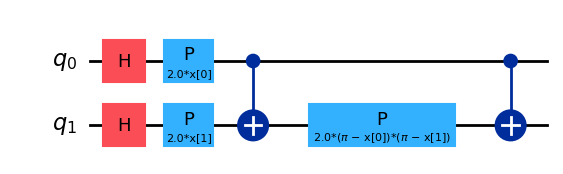

Ansatz Circuit:


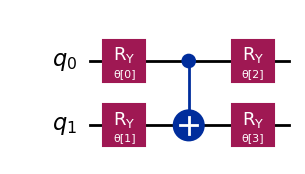

Combined Circuit (Feature Map + Ansatz) for a Sample Input:


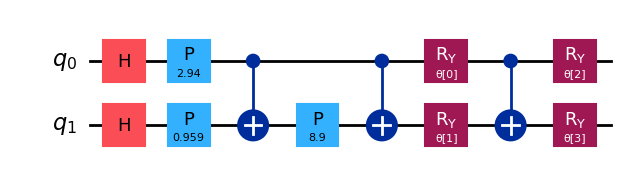

     ┌───┐┌─────────────┐                                          
q_0: ┤ H ├┤ P(2.0*x[0]) ├──■────────────────────────────────────■──
     ├───┤├─────────────┤┌─┴─┐┌──────────────────────────────┐┌─┴─┐
q_1: ┤ H ├┤ P(2.0*x[1]) ├┤ X ├┤ P(2.0*(π - x[0])*(π - x[1])) ├┤ X ├
     └───┘└─────────────┘└───┘└──────────────────────────────┘└───┘
     ┌──────────┐     ┌──────────┐
q_0: ┤ Ry(θ[0]) ├──■──┤ Ry(θ[2]) ├
     ├──────────┤┌─┴─┐├──────────┤
q_1: ┤ Ry(θ[1]) ├┤ X ├┤ Ry(θ[3]) ├
     └──────────┘└───┘└──────────┘

 VQC Accuracy: 0.56

Classification Report:
               precision    recall  f1-score   support

           0       0.56      0.59      0.58       125
           1       0.57      0.54      0.55       124

    accuracy                           0.57       249
   macro avg       0.57      0.57      0.57       249
weighted avg       0.57      0.57      0.57       249

Confusion Matrix:
 [[74 51]
 [57 67]]


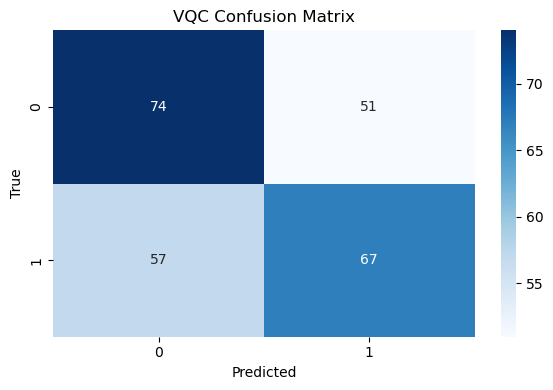

In [166]:
'''
Creates and trains a Variational Quantum Classifier (VQC) using Qiskit Machine Learning

Steps:
1. Define quantum feature map and ansatz circuit structures.
2. Set optimization algorithm and quantum sampler.
3. Visualize the feature map and ansatz circuit structures.
4. Build and combine the full quantum circuit.
5. Train the VQC on the PCA-reduced and oversampled classical dataset.
6. Make predictions on the test set.
7. Evaluate performance using accuracy, classification report, and confusion matrix.
8. Visualize the final confusion matrix as a heatmap.
'''


feature_map = ZZFeatureMap(feature_dimension=2, reps=1)
ansatz = RealAmplitudes(num_qubits=2, reps=1)
optimizer = COBYLA(maxiter=100)
sampler = AerSampler()


print("Feature Map Circuit:")
display(feature_map.decompose().draw('mpl'))

print("Ansatz Circuit:")
display(ansatz.decompose().draw('mpl'))


vqc = VQC(
    feature_map=feature_map,
    ansatz=ansatz,
    optimizer=optimizer,
    sampler=sampler
)

print("Combined Circuit (Feature Map + Ansatz) for a Sample Input:")
sample_input = X_train[1]
bound_feature_map = feature_map.assign_parameters(sample_input)
combined_circuit = bound_feature_map.compose(ansatz)
display(combined_circuit.decompose().draw('mpl'))


vqc.fit(X_train, y_train.to_numpy())
y_pred = vqc.predict(X_test)
y_test_array = y_test.to_numpy()
accuracy = vqc.score(X_test, y_test_array)


print(feature_map.decompose().draw('text'))
print(ansatz.decompose().draw('text'))


print(f"\n VQC Accuracy: {accuracy:.2f}")
print("\nClassification Report:\n", classification_report(y_test_array, y_pred))
print("Confusion Matrix:\n", confusion_matrix(y_test_array, y_pred))


plt.figure(figsize=(6, 4))
sns.heatmap(confusion_matrix(y_test_array, y_pred), annot=True, fmt='d', cmap='Blues')
plt.title("VQC Confusion Matrix")
plt.xlabel("Predicted")
plt.ylabel("True")
plt.tight_layout()
plt.show()


## **Quantum support vector machine (QSVM)**

C:\Users\IGHAL\AppData\Local\Temp\ipykernel_43184\3742167984.py:23: DeprecationWarning: V1 Primitives are deprecated as of qiskit-machine-learning 0.8.0 and will be removed no sooner than 4 months after the release date. Use V2 primitives for continued compatibility and support.
  fidelity = ComputeUncompute(sampler=sampler)


QSVM Accuracy: 0.63

Classification Report:
               precision    recall  f1-score   support

           0       0.66      0.53      0.59       125
           1       0.60      0.73      0.66       124

    accuracy                           0.63       249
   macro avg       0.63      0.63      0.62       249
weighted avg       0.63      0.63      0.62       249

Confusion Matrix:
 [[66 59]
 [34 90]]


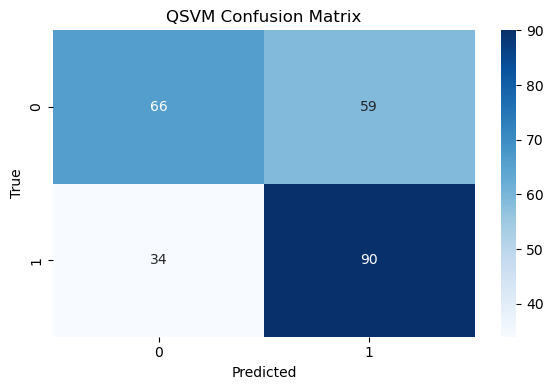

In [167]:
'''
This code implements a quantum support vector machine (QSVM) using a quantum kernel with a Fidelity-based approach. 

1. Quantum Feature Map: A ZZFeatureMap is created to map classical data into quantum states for processing by a quantum algorithm.
2. Quantum Simulator: The AerSimulator is set up to simulate quantum operations, using the statevector method to represent quantum states.
3. Sampler: A Sampler object is created to sample from quantum circuits, which is required for the quantum kernel.
4. Fidelity Calculation**: The ComputeUncompute operator is used to calculate the fidelity (similarity) between quantum states. This is important in measuring how close two quantum states are to each other.
5. Quantum Kernel: A FidelityQuantumKernel is generated using the feature map and fidelity instance. This kernel is used to measure similarity in a quantum manner and is essential for the QSVM classifier.
6. QSVM Model: A QSVM classifier is initialized with the quantum kernel and trained on the provided training data.
7. Model Training: The QSVM model is trained on the training dataset to learn the relationship between the input features and the target labels.
8. Predictions: The trained QSVM model is used to predict the target labels on the test set.
9. Model Evaluation: The performance of the model is evaluated using accuracy, classification report, and confusion matrix.
10.Confusion Matrix Visualization: The confusion matrix is plotted to visualize the model's classification performance.

'''

feature_map = ZZFeatureMap(feature_dimension=2, reps=1) 

simulator = AerSimulator(method='statevector')

sampler = Sampler()

fidelity = ComputeUncompute(sampler=sampler)

quantum_kernel = FidelityQuantumKernel(
    feature_map=feature_map,
    fidelity=fidelity
)

qsvc = QSVC(quantum_kernel=quantum_kernel)
qsvc.fit(X_train, y_train)
y_pred = qsvc.predict(X_test)
accuracy = qsvc.score(X_test, y_test)

print(f"QSVM Accuracy: {accuracy:.2f}")
print("\nClassification Report:\n", classification_report(y_test, y_pred))
print("Confusion Matrix:\n", confusion_matrix(y_test, y_pred))

plt.figure(figsize=(6, 4))
sns.heatmap(confusion_matrix(y_test, y_pred), annot=True, fmt='d', cmap='Blues')
plt.title("QSVM Confusion Matrix")
plt.xlabel("Predicted")
plt.ylabel("True")
plt.tight_layout()
plt.show()


# **Quantum Neural Network (QNN)**

C:\Users\IGHAL\AppData\Local\Temp\ipykernel_43184\592978048.py:35: DeprecationWarning: V1 Primitives are deprecated as of qiskit-machine-learning 0.8.0 and will be removed no sooner than 4 months after the release date. Use V2 primitives for continued compatibility and support.
  qnn = EstimatorQNN(circuit=qc, input_params=feature_map.parameters, weight_params=ansatz.parameters )


Epoch 1/60 - Loss: 0.6853
Epoch 2/60 - Loss: 0.6763
Epoch 3/60 - Loss: 0.6672
Epoch 4/60 - Loss: 0.6582
Epoch 5/60 - Loss: 0.6492
Epoch 6/60 - Loss: 0.6404
Epoch 7/60 - Loss: 0.6316
Epoch 8/60 - Loss: 0.6231
Epoch 9/60 - Loss: 0.6147
Epoch 10/60 - Loss: 0.6066
Epoch 11/60 - Loss: 0.5988
Epoch 12/60 - Loss: 0.5913
Epoch 13/60 - Loss: 0.5841
Epoch 14/60 - Loss: 0.5772
Epoch 15/60 - Loss: 0.5708
Epoch 16/60 - Loss: 0.5647
Epoch 17/60 - Loss: 0.5590
Epoch 18/60 - Loss: 0.5537
Epoch 19/60 - Loss: 0.5489
Epoch 20/60 - Loss: 0.5444
Epoch 21/60 - Loss: 0.5403
Epoch 22/60 - Loss: 0.5365
Epoch 23/60 - Loss: 0.5331
Epoch 24/60 - Loss: 0.5300
Epoch 25/60 - Loss: 0.5271
Epoch 26/60 - Loss: 0.5246
Epoch 27/60 - Loss: 0.5222
Epoch 28/60 - Loss: 0.5200
Epoch 29/60 - Loss: 0.5181
Epoch 30/60 - Loss: 0.5163
Epoch 31/60 - Loss: 0.5146
Epoch 32/60 - Loss: 0.5131
Epoch 33/60 - Loss: 0.5117
Epoch 34/60 - Loss: 0.5105
Epoch 35/60 - Loss: 0.5093
Epoch 36/60 - Loss: 0.5083
Epoch 37/60 - Loss: 0.5073
Epoch 38/6

c:\Users\IGHAL\anaconda3\Lib\site-packages\sklearn\metrics\_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
c:\Users\IGHAL\anaconda3\Lib\site-packages\sklearn\metrics\_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
c:\Users\IGHAL\anaconda3\Lib\site-packages\sklearn\metrics\_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


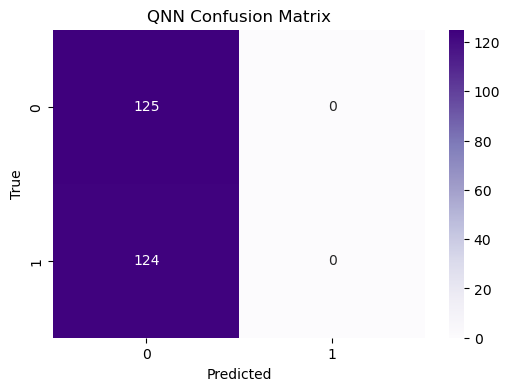

In [168]:
'''
This section implements a Quantum Neural Network (QNN) for binary classification using Qiskit and PyTorch.

1. Converts preprocessed PCA-reduced data into PyTorch tensors for compatibility with the QNN.
2. Builds a parameterized quantum circuit using a ZZFeatureMap and a TwoLocal ansatz to encode input features and enable learning.
3. Wraps the quantum circuit with Qiskit's `EstimatorQNN`, and integrates it into a PyTorch model using `TorchConnector`.
4. Trains the QNN using mean squared error loss and the Adam optimizer for a fixed number of epochs.
5. Evaluates model performance using accuracy, classification report, and confusion matrix.
6. Visualizes the confusion matrix to help interpret classification results.

'''



# Convert to PyTorch tensors
X_train_tensor = torch.tensor(X_train, dtype=torch.float32)
X_test_tensor = torch.tensor(X_test, dtype=torch.float32)
y_train_tensor = torch.tensor(y_train.values, dtype=torch.float32).unsqueeze(1)
y_test_tensor = torch.tensor(y_test.values, dtype=torch.float32).unsqueeze(1)




# ---Build Quantum Neural Network-----
num_inputs = 2

feature_map = ZZFeatureMap(feature_dimension=num_inputs, reps=1)
ansatz = TwoLocal(num_qubits=num_inputs, rotation_blocks='ry', entanglement_blocks='cz', reps=2)

qc = QuantumCircuit(num_inputs)
qc.compose(feature_map, inplace=True)
qc.compose(ansatz, inplace=True)


qnn = EstimatorQNN(circuit=qc, input_params=feature_map.parameters, weight_params=ansatz.parameters )
model = TorchConnector(qnn)


#--------Train the QNN-------------
loss_fn = nn.MSELoss()
optimizer = torch.optim.Adam(model.parameters(), lr=0.01)

epochs = 60
for epoch in range(epochs):
    model.train()
    optimizer.zero_grad()
    predictions = model(X_train_tensor)
    loss = loss_fn(predictions, y_train_tensor)
    loss.backward()
    optimizer.step()
    print(f"Epoch {epoch + 1}/{epochs} - Loss: {loss.item():.4f}")


# ------Evaluate the QNN-----------
model.eval()
with torch.no_grad():
    y_pred = model(X_test_tensor).numpy()

y_pred_binary = (y_pred > 0.5).astype(int).flatten()
y_test_array = y_test_tensor.numpy().flatten()

#--- Evaluation Metrics --------------
accuracy = accuracy_score(y_test_array, y_pred_binary)
print(f"\n QNN Accuracy: {accuracy:.2f}")

print("\nClassification Report:\n", classification_report(y_test_array, y_pred_binary))


cm = confusion_matrix(y_test_array, y_pred_binary)
print("Confusion Matrix:\n", cm)


plt.figure(figsize=(6, 4))
sns.heatmap(cm, annot=True, fmt='d', cmap='Purples')
plt.title("QNN Confusion Matrix")
plt.xlabel("Predicted")
plt.ylabel("True")
plt.show()
